<img src = "img/IBM_logo.png">

<h1 style="color:dodgerblue;text-align:center;"><b>Two Week Notice</b><br> An Outlier Analysis of IBM HR Analytics Attrition Data</h1>

## 1. Executive Summary

<p style="text-align:justify;">"It is said that employees don't leave companies, they leave people." (Dale Carnegie). Employee attrition is a challenge faced by both employers and employees. Employers typically don't want to incur the costs of lost productivity and hiring while employees who are satified within their current work environment wouldn't typically leave. This project proposed a methology of detecting employees who are prone to resigning by comparing the similarity of their profile with that of records from all employees within the organization using Gower's Distance. Gower's Distance is a metric that quantifies the similarity of numerical and categorical data between two records, with the assumption that an employee with a different profile from others in the organization would be at risk of resigning. Statistical-based outlier analysis was employed using p-values to determine the threshold for outliers. Profiles who have resigned are considered outliers while e ployees currently working in the organization would be the inliers. By detecting potential outliers early on, management could provide intervention to for the employees at risk of attrition.</p>

<p style="text-align:justify;">Recall was the chosen metric for this project because a company would not want to produce any false negatives while false positives would be far more acceptable to be able to campture any potential attrition case with intervention. Using IBM's HR Analytics Employee Attrition and Performance dataset, our methodology produced a recall score of <b>92%</b>. While classification methods produced a higher accuracy of 97% these methods needed oversampling and aren't directly interpretable. On the other hand, the use of Gower's Distance is directly interpretable because it simply uses the similarity between a profile to other profiles. The authors recommend for future study an optimal frequency of updating the set threshold, since the features of the employee records would change from time to time, finding the ideal number of employee samples used to compare profiles for the test set and expanding the use of this methodology to monitor current employee engagement and identifying candidates who are good fits during the hiring process.</p>

## 2. Problem Statement

<p style="color:dodgerblue;text-align:center;"><i>How might we detect employees who are prone to attriting?</i></p>

## 3. Motivation

<p style="text-align:justify;">Employee attrition is a big concern for employers as it impacts all forms of businesses. These resignations produce loss of productivity and costs for the company caused by having to rebuild the lost manpower. Detecting employees who are prone to attriting would allow companies to perform interventions that may prevent potential resignations. With this project, the authors hope to help companies not just to reduce costs coming from attrition, but to build up organizations full of like minded people with shared vision working towards a common goal.</p>

<img src = "img/Employee-Attrition.png">

## 4. Scope and Limitations

<b>Scope</b>
<p style="text-align:justify;">The scope of the study includes only the anonymized employees of IBM in their dataset. This study will also not go in depth into what mitigations can be done by HR to prevent potential attrition.</p>

<b>Limitations</b>
<p style="text-align:justify;">Because the methodology depends on employee input, surveys would need to be regularly conducted for updated employee profiles. Additionally, the accuracy would also be dependent on how transparent the employees would be on their self assessment.</p>

In [1]:
import utils
import time
import gower
import random
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.manifold import TSNE
%matplotlib inline

from IPython.display import HTML
from IPython.display import Image as _image

from scipy.stats import t, mannwhitneyu
from sklearn.preprocessing import LabelEncoder

from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from sklearn.metrics import (confusion_matrix, classification_report,
                             recall_score)

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<style>
.output_png {
    display: table-cell;
    text-align: center;
    horizontal-align: middle;
    vertical-align: middle;
    margin:auto;
}

tbody, thead {
    margin-left:100px;
}

</style>
<form action="javascript:code_toggle()"><input type="submit"
value="Click here to toggle on/off the raw code."></form>''')

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-7y9z4a24 because the default path (/home/casoriano/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## 5. Dataset

<p style="text-align:justify;"><a href="https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset"> IBM’s HR Analytics Employee Attrition & Performance</a> is a dataset synthesized by IBM Data Scientists. The dataset contains 1470 rows of employee records each with 35 columns of features.</p>

<p style="text-align:center;"><b>Table 1.</b> Description of the Features of the Dataset.</p>

| Feature | Description |
| --- | --- |
| AGE | Numerical Value |
| ATTRITION | Employee leaving the company (0=no, 1=yes) |
| BUSINESS TRAVEL | (1=No Travel, 2=Travel Frequently, 3=Tavel Rarely)|
| DAILY RATE | Numerical Value - Salary Level |
| DEPARTMENT | (1=HR, 2=R&D, 3=Sales) |
| DISTANCE FROM HOME | Numerical Value - THE DISTANCE FROM WORK TO HOME |
| EDUCATION | Numerical Value |
| EDUCATION FIELD | (1=HR, 2=LIFE SCIENCES, 3=MARKETING, 4=MEDICAL SCIENCES, 5=OTHERS, 6= TEHCNICAL) |
| EMPLOYEE COUNT | Numerical Value |
| EMPLOYEE NUMBER | Numerical Value - EMPLOYEE ID |
| ENVIROMENT SATISFACTION | Numerical Value - SATISFACTION WITH THE ENVIROMENT |
| GENDER | (1=FEMALE, 2=MALE) |
| HOURLY RATE | Numerical Value - HOURLY SALARY |
| JOB INVOLVEMENT | Numerical Value - JOB INVOLVEMENT |
| JOB LEVEL | Numerical Value - LEVEL OF JOB |
| JOB ROLE | (1=HC REP, 2=HR, 3=LAB TECHNICIAN, 4=MANAGER, 5= MANAGING DIRECTOR, 6= REASEARCH DIRECTOR, 7= RESEARCH SCIENTIST, 8=SALES EXECUTIEVE, 9= SALES REPRESENTATIVE) |
| JOB SATISFACTION | Numerical Value - SATISFACTION WITH THE JOB |
| MARITAL STATUS | (1=DIVORCED, 2=MARRIED, 3=SINGLE) |
| MONTHLY INCOME | Numerical Value - MONTHLY SALARY |
| MONTHY RATE | Numerical Value - MONTHY RATE |
| NUMCOMPANIES WORKED | Numerical Value - NO. OF COMPANIES WORKED AT |
| OVER 18 | (1=YES, 2=NO) |
| OVERTIME | (1=NO, 2=YES) |
| PERCENT SALARY HIKE | Numerical Value - PERCENTAGE INCREASE IN SALARY |
| PERFORMANCE RATING | Numerical Value - ERFORMANCE RATING |
| RELATIONS SATISFACTION | Numerical Value - RELATIONS SATISFACTION |
| STANDARD HOURS | Numerical Value - STANDARD HOURS |
| STOCK OPTIONS LEVEL | Numerical Value - STOCK OPTIONS |
| TOTAL WORKING YEARS | Numerical Value - TOTAL YEARS WORKED |
| TRAINING TIMES LAST YEAR | Numerical Value - HOURS SPENT TRAINING |
| WORK LIFE BALANCE | Numerical Value - TIME SPENT BEWTWEEN WORK AND OUTSIDE |
| YEARS AT COMPANY | Numerical Value - TOTAL NUMBER OF YEARS AT THE COMPNAY |
| YEARS IN CURRENT ROLE | Numerical Value -YEARS IN CURRENT ROLE |
| YEARS SINCE LAST PROMOTION | Numerical Value - LAST PROMOTION |
| YEARS WITH CURRENT MANAGER | Numerical Value - YEARS SPENT WITH CURRENT MANAGER |

Below is a sample of the table.

<p style="text-align:center;"><b>Table 2.</b> The Attrition Dataset.</p>

In [2]:
# drop single value columns
drop_cols = ['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours']
data = pd.read_csv('data.csv').drop(drop_cols, axis=1)
display(data.head())

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Yes,11,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,No,23,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Yes,15,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Yes,11,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,No,12,3,4,1,6,3,3,2,2,2,2


## 6. Methodology

<img src = 'img/methodology.png'>

<p style="text-align:center;"><b>Figure 1.</b> The project methodology. It involves three main outlier analysis models.</p>

### 6.1 Data Preprocessing

<p style="text-align:justify;">With the data types being a mixed, preprocessing was done to be able to work with it.</p>

#### Determine Categorical and Numerical Variables

<p style="text-align:justify;">There are 19 categorical and 16 numerical features. In general, employee records will always have a mix of categorical and numerical features. Determining the categorical and numerical variables was needed because each has a different preprocessing method.</p>

In [3]:
# list categorical and numerical variables
cat = ['BusinessTravel', 'Department', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel',
       'JobRole', 'JobSatisfaction', 'MaritalStatus', 'OverTime',
       'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel',
       'WorkLifeBalance']
num = ['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome',
       'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

<p style="text-align:center;"><b>Table 3.</b> The categorical features. It is composed of nominal and ordinal data.</p>

In [4]:
data_cat = data[cat]
display(data_cat.head())

,BusinessTravel,Department,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,OverTime,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,WorkLifeBalance
0,Travel_Rarely,Sales,2,Life Sciences,2,Female,3,2,Sales Executive,4,Single,Yes,3,1,0,1
1,Travel_Frequently,Research & Development,1,Life Sciences,3,Male,2,2,Research Scientist,2,Married,No,4,4,1,3
2,Travel_Rarely,Research & Development,2,Other,4,Male,2,1,Laboratory Technician,3,Single,Yes,3,2,0,3
3,Travel_Frequently,Research & Development,4,Life Sciences,4,Female,3,1,Research Scientist,3,Married,Yes,3,3,0,3
4,Travel_Rarely,Research & Development,1,Medical,1,Male,3,1,Laboratory Technician,2,Married,No,3,4,1,3


<p style="text-align:center;"><b>Table 4.</b> The numerical features.</p>

In [5]:
data_num = data[num]
display(data_num.head())

,Age,DailyRate,DistanceFromHome,HourlyRate,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1102,1,94,5993,19479,8,11,8,0,6,4,0,5
1,49,279,8,61,5130,24907,1,23,10,3,10,7,1,7
2,37,1373,2,92,2090,2396,6,15,7,3,0,0,0,0
3,33,1392,3,56,2909,23159,1,11,8,3,8,7,3,0
4,27,591,2,40,3468,16632,9,12,6,3,2,2,2,2


#### Separate into Inliers and Outliers

<p style="text-align:justify;">The data contains 1233 current employees as inliers and 237 noncurrent employees who have attrited as outliers. This amounts to about 19% of their employees.</p>

In [27]:
inliers = data[data['Attrition'] == 'No'].drop('Attrition', axis=1)
outliers = data[data['Attrition'] == 'Yes'].drop('Attrition', axis=1)
ratio = len(outliers) / len(inliers)

print('Number of inliers:', len(inliers), '\nNumber of outliers:',
      len(outliers), '\nRatio of Outliers to Inliers:', round(ratio, 3))

Number of inliers: 1233 
Number of outliers: 237 
Ratio of Outliers to Inliers: 0.192


#### Apply Label Encoding on Nominal Data

<p style="text-align:justify;">Nominal Features are label encoded. The ordinal data is kept as is.</p>

<p style="text-align:center;"><b>Table 5.</b> The whole dataset after preprocessing.</p>

In [7]:
data_cat_str = data_cat.select_dtypes(include='object').apply(LabelEncoder().fit_transform)
df_e = data_cat_str.join(data_cat.select_dtypes(exclude='object'))
df_e = df_e.join(data_num)
df_e = df_e.reindex(sorted(df_e.columns), axis=1)
display(df_e.head())

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,2,1102,2,1,2,1,2,0,94,3,2,7,4,2,5993,19479,8,1,11,3,1,0,8,0,1,6,4,0,5
1,49,1,279,1,8,1,1,3,1,61,2,2,6,2,1,5130,24907,1,0,23,4,4,1,10,3,3,10,7,1,7
2,37,2,1373,1,2,2,4,4,1,92,2,1,2,3,2,2090,2396,6,1,15,3,2,0,7,3,3,0,0,0,0
3,33,1,1392,1,3,4,1,4,0,56,3,1,6,3,1,2909,23159,1,1,11,3,3,0,8,3,3,8,7,3,0
4,27,2,591,1,2,1,3,1,1,40,3,1,2,2,1,3468,16632,9,0,12,3,4,1,6,3,3,2,2,2,2


#### Separate into Train and Test Sets

<p style="text-align:justify;">We segment our inliers into a 80-20 train-test split. The test set also contains all the outliers.</p>

In [8]:
random.seed(42)
sample_idx = random.sample(list(inliers.index), round(len(outliers)/5))

In [28]:
train = df_e.loc[inliers.index.drop(sample_idx)]
inliers_test = df_e.loc[sample_idx]
test = inliers_test.append(df_e.loc[outliers.index])

print('Train Set:', train.shape, '\nTest Set:', test.shape)

Train Set: (1186, 30) 
Test Set: (284, 30)


### 6.2 Exploratory Data Analysis

<p style="text-align:justify;">We explored the data to gain more insight.</p>

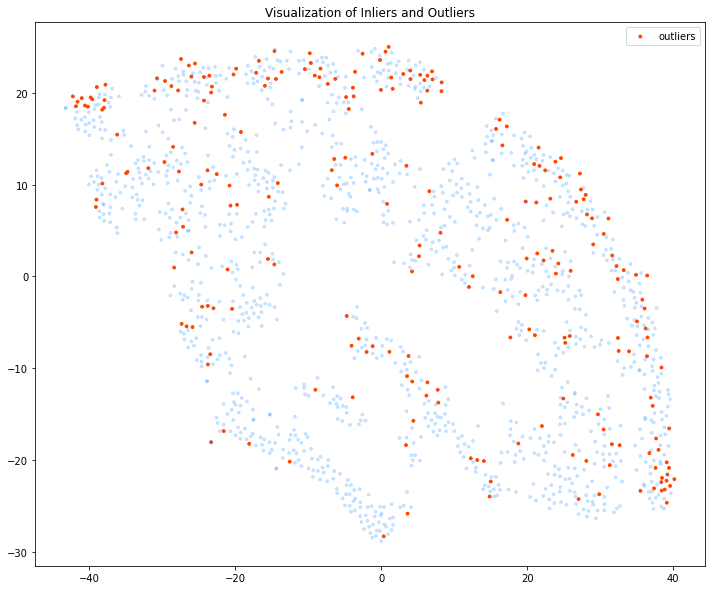

In [10]:
y = data['Attrition']
embedded = TSNE(n_components=2, n_jobs=-1, perplexity=50).fit_transform(df_e)

plt.figure(figsize=(12, 10))
plt.scatter(embedded[:, 0], embedded[:, 1], 
            c=y.map({'No': 'dodgerblue', 'Yes': 'orangered'}), s=8.,
            alpha=y.map({'No': 0.2, 'Yes': 1}), label='outliers')
plt.title('Visualization of Inliers and Outliers')
plt.legend()
plt.show()

<p style="text-align:center;"><b>Figure 2.</b> Visualization of Inliers and Outliers in Embedded Space. No linear separation is observed between outliers and inliers.</p>

#### Distribution of Inliers and Outliers per Feature

<p style="text-align:justify;">This helps us distinguish important features. Similar distributions between the inlier and outlier class tend to not add value to the models.</p>

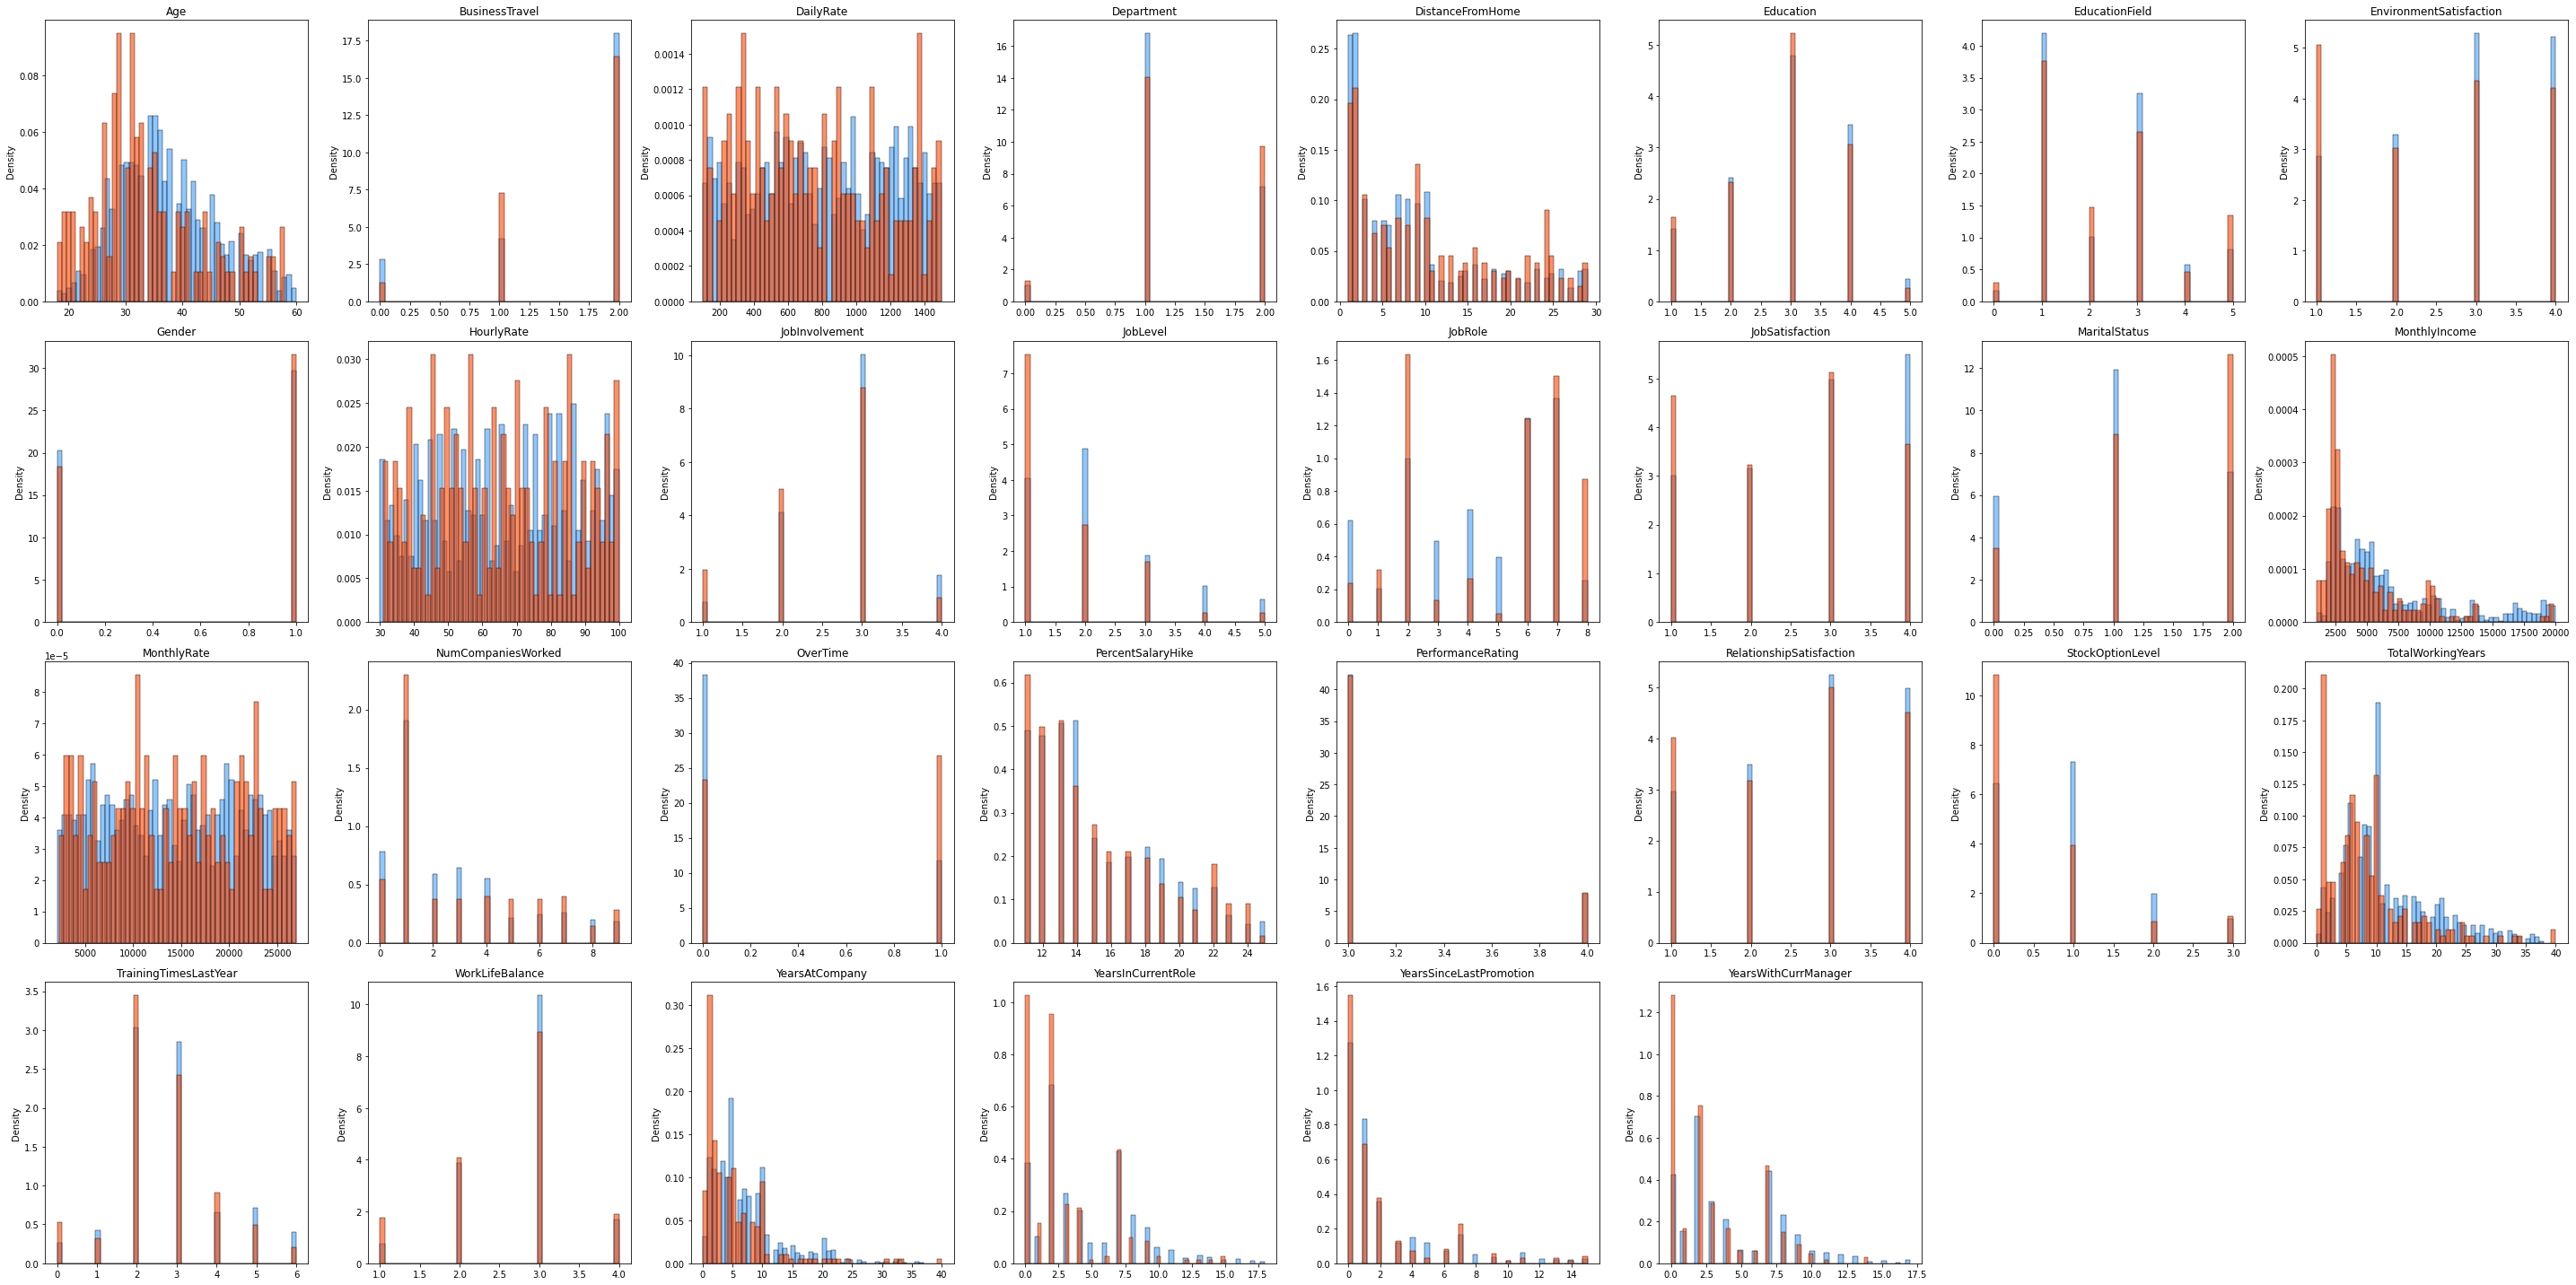

In [11]:
grid = gridspec.GridSpec(4, 8)
plt.figure(figsize=(40, 20))

for n, col in enumerate(inliers.columns.tolist()):
    ax = plt.subplot(grid[n])
    sns.histplot(df_e.loc[inliers.index][col], bins=50, color='dodgerblue', stat='density', alpha=0.5)
    sns.histplot(df_e.loc[outliers.index][col], bins=50, color='orangered', stat='density', alpha=0.6)
    ax.set_title(str(col))
    ax.set_xlabel('')
plt.tight_layout()
plt.show()

<p style="text-align:center;"><b>Figure 3.</b> Plots of our distribution for inliers and outliers per feature.</p>

#### Correlation Matrix



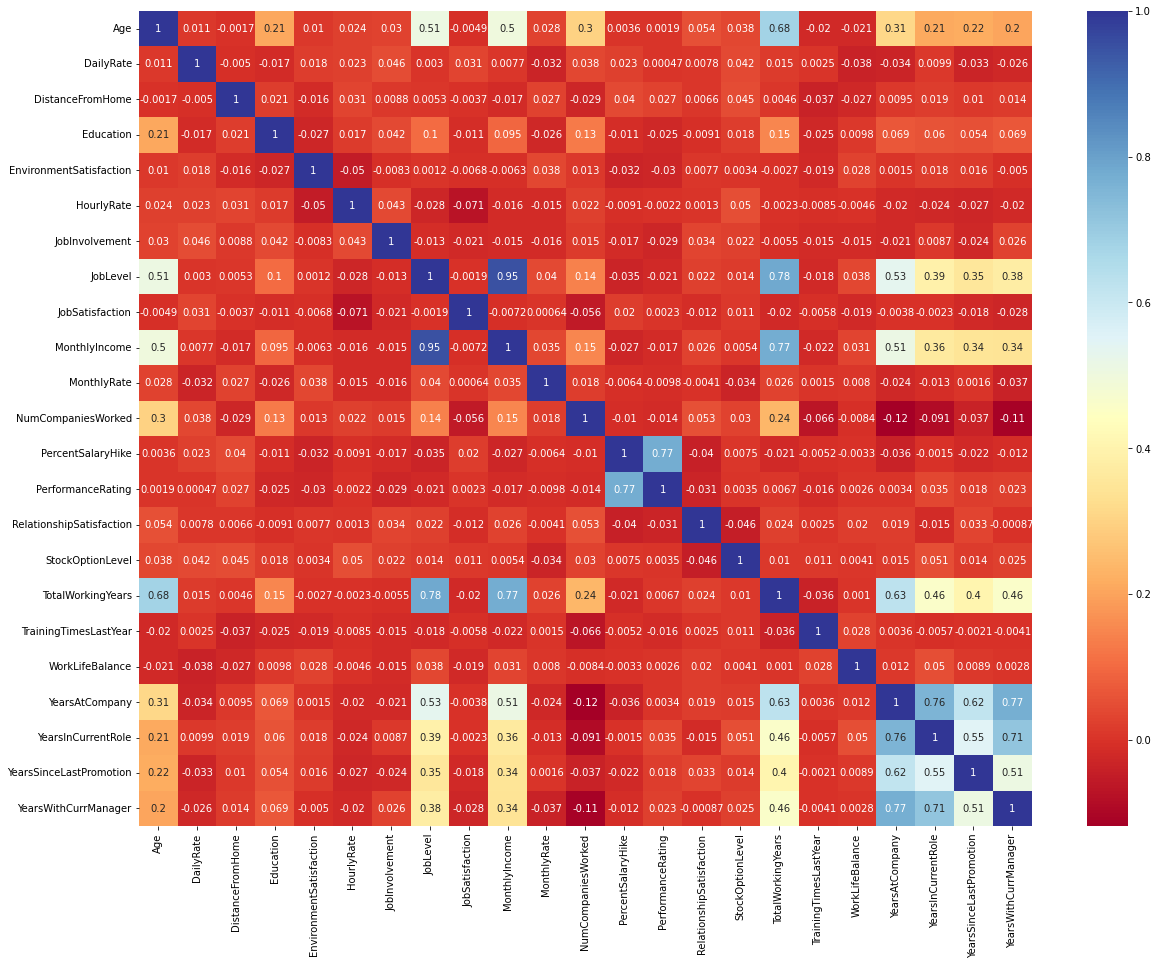

In [12]:
heatmap = data.corr()
top_feat = heatmap.index
plt.figure(figsize=(20,15))
p = sns.heatmap(data[top_feat].corr(), annot=True, cmap='RdYlBu')

<p style="text-align:center;"><b>Figure 4.</b> Heatmap for correlations within features.</p>

#### Summary Statistics for Numerical Data

<p style="text-align:justify;">Statistics such as the mean and standard deviation are displayed below.</p>

<p style="text-align:center;"><b>Table 6.</b> Summary statistics for numerical Data.</p>

In [13]:
display(data.describe())

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


### 6.3 Gower Distance

<p style="text-align:justify;">Gower distance measures the difference between two records. These records may contain logical or boolean, categorical, numerical or even text data. It gives a distance between 0 and 1 where the closer to 1, the more similar the two records are, the closer to 0, the less similar they are.</p>

$$D_{Gower}(x_1, x_2) = 1 - \left( \dfrac{1}{p}\sum_{j=1}^{p} s_j(x_1, x_2)\right)$$

<p style="text-align:justify;">Here is the formula where the term sj(x1, x2) is the partial similarity function computed separately for each feature. To be able to handle both categorical and numerical data, it has a different formula for both.</p>

<p style="text-align:justify;">For numerical variables, the distance is calculated as the absolute value between the two records divided by the range of all possible records which scales their difference.</p>

$$s_j(x_1, x_2) = 1 - \dfrac{|y_{1j} - y_{2j}|}{R_j}$$

<p style="text-align:justify;">Meanwhile for categorical variables we use the Dice coefficient. The dice distance is given below where |X| and |Y| represent the cardinality or length of the two sets but since we’re only talking about 1 feature and two data points at a time, the values can only be either 1 or 0. Essentially, this means that if they are the same, the dice distance is 1. If not, it is 0.</p>

$$DSC = \dfrac{2 |X \cap Y|}{|X| + |Y|}$$

#### Generate Gower Distance Matrix for Train Data

<p style="text-align:justify;">This is a matrix of Gower distances of each record in the train set to one another i.e. all the employees currently in the company.</p>

<p style="text-align:center;"><b>Table 7.</b> The Gower Distance Matrix for Inliers.</p>

In [14]:
dist_matrix = 1 - gower.gower_matrix(
    train.astype(float), cat_features=[i in cat for i in train.columns])
x = np.array([dist_matrix[i][dist_matrix[i] != dist_matrix[i][i]]
              for i in range(len(dist_matrix))]).mean(axis=0)
display(pd.DataFrame(dist_matrix))

0         1         2         3         4         5         6     \
0     1.000000  0.562528  0.622793  0.521782  0.470291  0.597971  0.650944   
1     0.562528  1.000000  0.569688  0.702411  0.519104  0.589217  0.551699   
2     0.622793  0.569688  1.000000  0.593642  0.536935  0.658141  0.440866   
3     0.521782  0.702411  0.593642  1.000000  0.488227  0.620717  0.621614   
4     0.470291  0.519104  0.536935  0.488227  1.000000  0.542209  0.405896   
...        ...       ...       ...       ...       ...       ...       ...   
1181  0.477526  0.623743  0.572339  0.573290  0.489918  0.584307  0.601412   
1182  0.637770  0.548266  0.670484  0.654665  0.567051  0.579614  0.536514   
1183  0.647968  0.533298  0.701094  0.527481  0.523442  0.565575  0.600358   
1184  0.650662  0.489875  0.569435  0.465911  0.583003  0.617566  0.624562   
1185  0.653207  0.545816  0.583098  0.635043  0.505855  0.434278  0.584872   

          7         8         9         10        11        12        13    \
0     0.517835  0.577464  0.577044  0.599005  0.471429  0.481598  0.363895   
1     0.514465  0.570428  0.665227  0.583108  0.571720  0.597967  0.520026   
2     0.592811  0.789153  0.563389  0.729848  0.706202  0.506195  0.538351   
3     0.562921  0.628259  0.652000  0.627836  0.723298  0.534213  0.678198   
4     0.556904  0.611193  0.477969  0.446006  0.526133  0.455428  0.596237   
...        ...       ...       ...       ...       ...       ...       ...   
1181  0.463702  0.564728  0.688697  0.589645  0.532250  0.487139  0.473529   
1182  0.631605  0.747276  0.575131  0.569834  0.732490  0.571698  0.621292   
1183  0.606284  0.667290  0.568113  0.575181  0.572367  0.601987  0.464833   
1184  0.522929  0.654567  0.559369  0.522576  0.554388  0.576798  0.532915   
1185  0.628809  0.599903  0.584871  0.497681  0.474967  0.415896  0.505210   

          14        15        16        17        18        19        20    \
0     0.511888  0.505717  0.505948  0.541978  0.584255  0.480598  0.681904   
1     0.611414  0.732817  0.467906  0.675073  0.600783  0.505035  0.572087   
2     0.483434  0.645983  0.547156  0.608799  0.637312  0.529481  0.697976   
3     0.548740  0.729853  0.540238  0.632444  0.700194  0.502260  0.525204   
4     0.427742  0.523732  0.484002  0.385837  0.457656  0.523534  0.417547   
...        ...       ...       ...       ...       ...       ...       ...   
1181  0.570469  0.620865  0.570512  0.571029  0.614511  0.543757  0.575768   
1182  0.501182  0.579205  0.595041  0.495229  0.598311  0.480281  0.618883   
1183  0.546150  0.570662  0.481489  0.598068  0.530153  0.505470  0.624408   
1184  0.413842  0.598905  0.556982  0.483394  0.510154  0.394194  0.566791   
1185  0.578453  0.531262  0.507069  0.503916  0.479246  0.541727  0.677010   

          21        22        23        24        25        26        27    \
0     0.553686  0.395904  0.516808  0.517199  0.536152  0.503274  0.431510   
1     0.497168  0.517400  0.584962  0.652215  0.584200  0.651762  0.648611   
2     0.635647  0.515730  0.754588  0.599151  0.649916  0.606931  0.611997   
3     0.448564  0.552290  0.727880  0.589086  0.713809  0.636363  0.643181   
4     0.445456  0.478797  0.634820  0.486223  0.531233  0.609911  0.577407   
...        ...       ...       ...       ...       ...       ...       ...   
1181  0.506034  0.599026  0.665023  0.577446  0.669903  0.655205  0.732816   
1182  0.586750  0.396561  0.678662  0.576935  0.609908  0.560343  0.533364   
1183  0.729899  0.483692  0.578063  0.629295  0.702879  0.568044  0.570542   
1184  0.455714  0.391094  0.532808  0.518972  0.500178  0.446539  0.508807   
1185  0.554367  0.560179  0.608425  0.611419  0.598610  0.597861  0.609653   

          28        29        30        31        32        33        34    \
0     0.553849  0.586872  0.544273  0.508548  0.545682  0.661658  0.522119   
1     0.659628  0.575616  0.580158  0.687020  0.618820  0.569616  0.544268   
2     0.642326  0.503783  0.

#### Determine p-value threshold for Gower Distance

<p style="text-align:justify;">This is a statistical method of determining the threshold for outliers.</p>

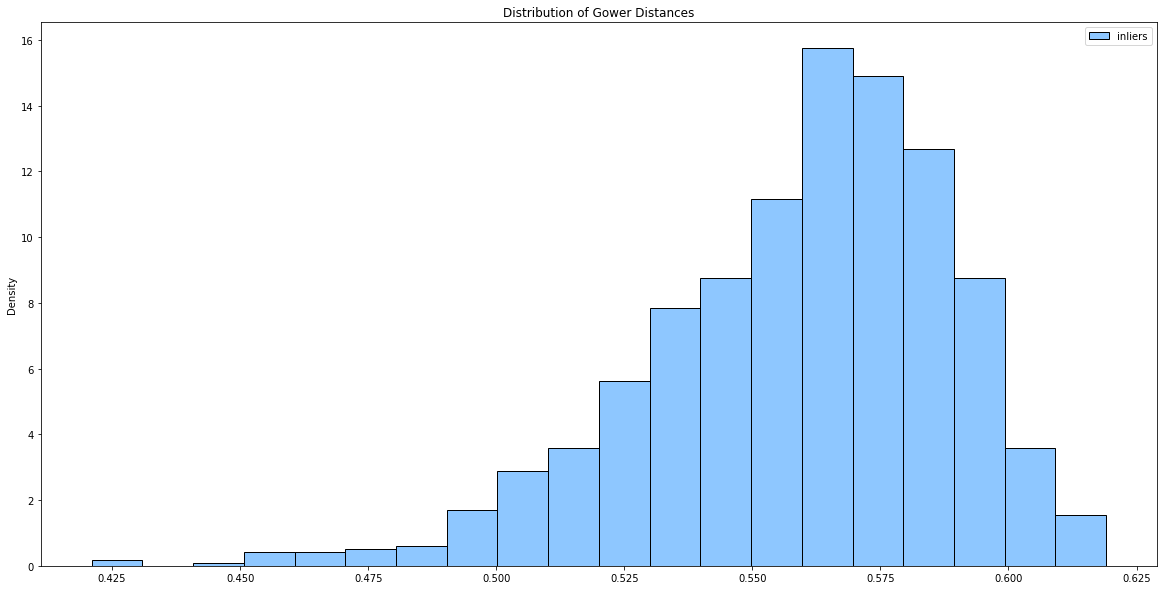

In [15]:
plt.figure(figsize=(20,10))

sns.histplot(dist_matrix.mean(axis=0), bins=20,
             color='dodgerblue', stat='density', alpha=0.5, label='inliers')
plt.title('Distribution of Gower Distances')
plt.legend()
plt.show()

<p style="text-align:center;"><b>Figure 5.</b> The Gower distance distribution for the train set composed of inliers. We assume that outliers will have a lower Gower Distance distribution compared to the actual inliers.</p>

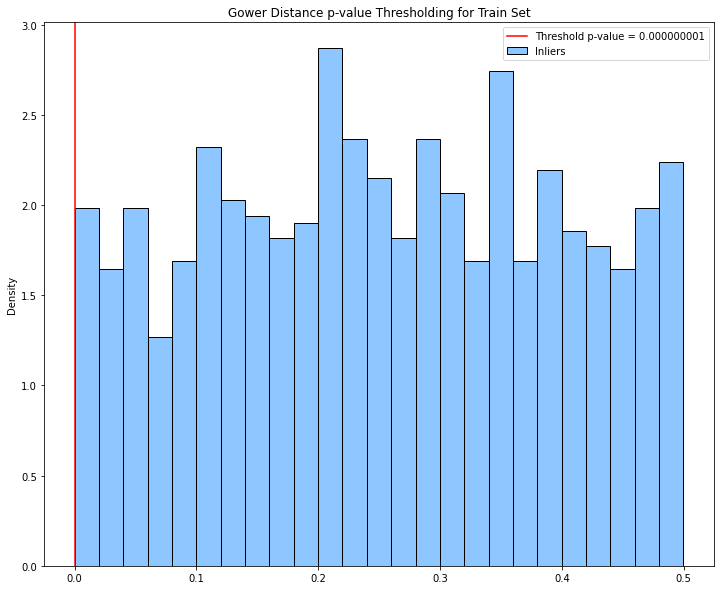

In [16]:
p_value = t.sf(np.abs((x - x.mean())/x.std()), x.shape[0]-1)

plt.figure(figsize=(12, 10))
ax = sns.histplot(p_value, color='dodgerblue', stat='density', alpha=0.5, label='Inliers', bins=25)
threshold = [i.get_x()/1e3 for i in ax.patches][0]
plt.axvline(threshold, color='red', label='Threshold p-value = {:.9f}'.format(threshold))
plt.title('Gower Distance p-value Thresholding for Train Set')
plt.legend()
plt.show()

<p style="text-align:center;"><b>Figure 6.</b> We set our threshold at 1.47e-9 the lowest p-value for all the inliers which represents a Gower distance of 0.421.</p>

#### Generate Gower Distance Matrix for Test

We again generate a matrix for the test set but compared to the train set.

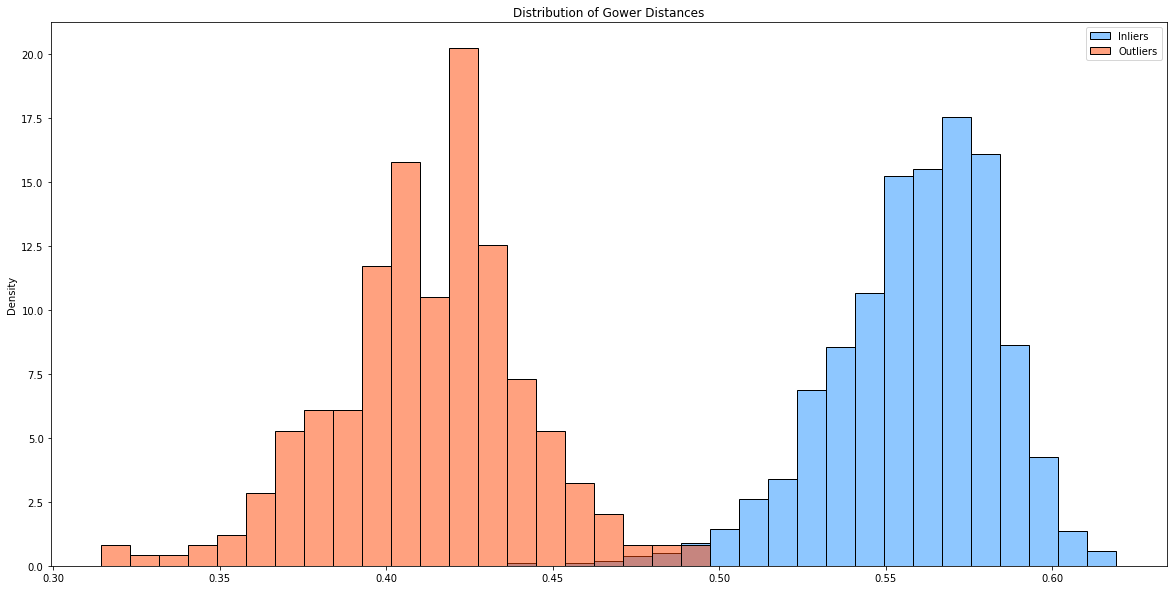

In [17]:
k = 100
test_results = np.array([np.mean(1 - gower.gower_topn(test.iloc[i:i+1],
    train.astype(float), n=train.shape[0],
    cat_features=[j in cat for j in train.columns])['values'][-k:])
    for i in range(test.shape[0])])

bins_ = np.histogram_bin_edges(np.concatenate((dist_matrix.mean(axis=0),
                                               test_results)), 35)
plt.figure(figsize=(20,10))
sns.histplot(x, color='dodgerblue', bins=bins_,
             stat='density', alpha=0.5, label='Inliers')
sns.histplot(test_results, color='orangered', bins=bins_, 
             stat='density', alpha=0.5, label='Outliers')
plt.title('Distribution of Gower Distances')
plt.legend()
plt.show()

<p style="text-align:center;"><b>Figure 7.</b> The overlap between our inliers and outliers are the current employees who are similar to the former employees who have resigned and would need intervention to prevent their attrition. </p>

### 6.4 Isolation Forest

<p style="text-align:justify;">We initially explored using Isolation Forest, due to its robustness, but it gave a very poor recall. We’re using recall as a metric because we’d rather have false positives over false negatives, because we’d want to be able to provide intervention for potential resignations. The results are shown below.</p>

In [18]:
IF = IsolationForest(n_estimators=500, contamination=ratio,
                     random_state=42, n_jobs=-1)
IF.fit(train)

pred_IF = IF.predict(test)
ground_truth = pd.get_dummies(data['Attrition'].loc[test.index],
                              drop_first=False)['No'].replace({0: -1})
print(confusion_matrix(ground_truth, pred_IF))
print(classification_report(ground_truth, pred_IF))

[[ 80 157]
 [ 14  33]]
              precision    recall  f1-score   support

          -1       0.85      0.34      0.48       237
           1       0.17      0.70      0.28        47

    accuracy                           0.40       284
   macro avg       0.51      0.52      0.38       284
weighted avg       0.74      0.40      0.45       284



### 6.5 Classification Models

<p style="text-align:justify;">Our methodology fares well when compared to using classifiers. One thing to note is our classifiers are able to provide the feature importance which contribute to the identification of being an outlier. These methods required several preprocessing steps such as feature engineering and standard scaling. Due to the imbalance of the dataset, we had to oversample using ADASYN which may contribute to overfitting.</p>

In [19]:
target = pd.get_dummies(data['Attrition'], drop_first=True)
features = data.drop('Attrition', axis=1)

dummy_fields = ['Gender', 'MaritalStatus', 'OverTime', 
                'BusinessTravel', 'Department', 'EducationField', 'JobRole']
for each in dummy_fields:
    dummies = pd.get_dummies(features[each], prefix=each, drop_first=True)
    features = pd.concat([features, dummies], axis=1)

features = features.drop(dummy_fields, axis=1)

# scale data
scaler = StandardScaler()
features_scaled = pd.DataFrame(data=scaler.fit_transform(features.astype(float)), 
                               columns=features.columns)

# resampling
ada = ADASYN(random_state=42)
X_res, y_res = ada.fit_resample(features_scaled, target)

X = X_res
y = y_res['Yes']

<p style="text-align:center;"><b>Table 8.</b> The results for binary classification using classical ML models for our dataset.</p>

In [20]:
# cols = ['Machine Learning Method', 'Test Recall', 'Best Parameter',
#         'Top Predictor Variable', 'Run Time']
# df = pd.DataFrame(columns=cols)

# df.loc[0] = utils.train_knn(X,y)
# df.loc[1] = utils.train_logistic(X,y,reg='l2')
# df.loc[2] = utils.train_logistic(X,y,reg='l1')
# df.loc[3] = utils.train_svm(X,y,reg='l2')
# df.loc[4] = utils.train_svm(X,y,reg='l1')
# df.loc[5] = utils.train_RF(X,y,reg='none')
# df.loc[6] = utils.train_GBM(X,y,reg='none')

# df2.to_csv('classification_results.csv', index=False)

results = pd.read_csv('classification_results.csv')
display(results)

,Machine Learning Method,Test Recall,Best Parameter,Top Predictor Variable,Run Time
0,kNN,0.845839,N_Neighbor = 2,NaN,150.980893
1,Logistic (l2),0.769732,C = 0.01,Department_Research & Development,51.402024
2,Logistic (l1),0.767289,C = 15,Department_Research & Development,88.759161
3,Linear SVM (l2),0.766117,C = 0.2,Department_Research & Development,71.479605
4,Linear SVM (l1),0.766120,C = 0.75,Department_Research & Development,69.079177
5,Random Forest,0.977613,Max_features = 0.1,OverTime_Yes,42.049453
6,Gradient Boosting Method,0.966811,Max_features = 0.7,OverTime_Yes,33.369607


## 7. Results and Discussion

<p style="text-align:justify;">Applying a threshold of 1.47e-9 for similar produced a recall of 92.13% with a Gower distance of 0.42. The threshold is the p-value representative of the employees with the lowest Gower distance score currently within the organization. These values serve as the minimum metric to data points, or employees, as inliers. While this is lower compared to the recall coming from our classifiers, our methodology has no need for feature engineering, scaling, or oversampling making this method very interpretable while allowing the use of a threshold.</p>

In [21]:
test_results_p = t.sf(np.abs((test_results - x.mean())/x.std()), x.shape[0]-1)
recall = recall_score(((pd.DataFrame(test_results_p, index=test.index) < threshold)*1),
    data.loc[test.index]['Attrition'].replace({'Yes': 1, 'No': 0}))
print('Recall: {:.4f}'.format(recall))

Recall: 0.9213


### Sample

<p style="text-align:justify;">Below, we try to predict two people if they will attrite based on their profiles. We do in fact confirm that our model can predict whether or not these two attrite.</p>

<p style="text-align:center;"><b>Table 9.</b> Sample test for two employees.</p>

In [22]:
example = data.iloc[[272, 0]].copy()
example.rename(index={0:'Olivia the Outlier',
                      272:'Isaac the Inlier'}, inplace=True)
display(example.T)

,Isaac the Inlier,Olivia the Outlier
Age,28,41
Attrition,No,Yes
BusinessTravel,Travel_Rarely,Travel_Rarely
DailyRate,1158,1102
Department,Research & Development,Sales
DistanceFromHome,9,1
Education,3,2
EducationField,Medical,Life Sciences
EnvironmentSatisfaction,4,2
Gender,Male,Female


In [23]:
isaac = np.mean(1 - gower.gower_topn(test.iloc[0:1, :],
    train.astype(float), n=train.shape[0],
    cat_features=[j in cat for j in train.columns])['values'][-k:])

print('Isaac the Inlier\nAttrition:',
      t.sf(np.abs((isaac - x.mean())/x.std()), x.shape[0]-1) < threshold)

Isaac the Inlier
Attrition: False


In [24]:
olivia = np.mean(1 - gower.gower_topn(test.iloc[272:273, :],
    train.astype(float), n=train.shape[0],
    cat_features=[j in cat for j in train.columns])['values'][-k:])

print('Olivia the Outlier\nAttrition:', t.sf(np.abs((olivia - x.mean())/x.std()), x.shape[0]-1) < threshold)

Olivia the Outlier
Attrition: True


## 8. Conclusion

<p style="text-align:justify;">This project shows how the implementation of Gower Distance may be used to determine how similar or different an employee profile is to a collection of mixed data records and may used to determine potential attrition of an employee if their profile matches that of other employees who have resigned. Unlike Classification Machine Learning methods, feature engineering, scaling, and resampling and is not needed to generate a recall comparable to the Classification Methods while offering the flexibility of setting a threshold and being far more explainable.</p>

## 9. Recommendations

<b>For Decision Makers</b>
1. Given a person's profile, a user can estimate how similar that profile is to employee records 
2. Users can set acceptable thresholds for similarity depending on external factors (ex: a higher threshold for a crowded job market, lower for a sparse job market) 
3. Easily interpretable and explainable 
4. Can be used to predict necessary intervention for potential resignation

<b>For Further Study</b>
1. Find the optimal frequency of updating the set threshold, since the features of the employee records would change from time to time
2. Finding the ideal number of employee samples used to compare profiles for the test set
3. Expand the use of this methodology to monitor current employee engagement and identifying candidates who are good fits during the hiring process.

## References

1. Example of calculating the Gower distance. James D. McCaffrey. (2020, April 22). Retrieved March 17, 2022, from https://jamesmccaffrey.wordpress.com/2020/04/21/example-of-calculating-the-gower-distance/ 
2. Kjytay. (2021, February 23). What is Gower's distance? Statistical Odds &amp; Ends. Retrieved March 17, 2022, from https://statisticaloddsandends.wordpress.com/2021/02/23/what-is-gowers-distance/ 
3. Pavansubhash. (2017, March 31). IBM HR Analytics Employee Attrition &amp; Performance. Kaggle. Retrieved March 17, 2022, from https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset 
4. Python package for Gower Distance. GitHub. (n.d.). Retrieved March 17, 2022, from https://github.com/wwwjk366/gower 
5. Rohan’s Four - Rohan Jain, A. S. (n.d.). IBM HR Analytics Employee Attrition &amp; Performance. Retrieved March 17, 2022, from http://inseaddataanalytics.github.io/INSEADAnalytics/groupprojects/January2018FBL/IBM_Attrition_VSS.html 
6. Yan, M. (2019, December 16). Introducing python package --- gower. Think.Data.Science. Retrieved March 17, 2022, from https://www.thinkdatascience.com/post/2019-12-16-introducing-python-package-gower/ 